# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [2]:
# Load mammal data
dat = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", encoding="ISO-8859-1").rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})

# Drop columns with greater than 40% of observations missing
dat_columns = dat.columns

for column in dat_columns:
    if ((dat[column].isna().sum())/(dat[column].shape[0])) >= 0.4:
        dat = dat.drop(columns=[column])

print(f"Final DataFrame shape: {dat.shape}")

Final DataFrame shape: (214, 17)


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [3]:
# Split numeric and categorical columns 
dat_cat = dat.select_dtypes(include=['object'])
dat_num = dat.select_dtypes(exclude=['object'])

# Impute NA values of numeric columns
num_imp = KNNImputer(n_neighbors = 5)
dat_num_imp = pd.DataFrame(data=num_imp.fit_transform(dat_num), columns=dat_num.columns)

# Impute NA values of categorical columns
cat_imp = SimpleImputer(strategy = 'most_frequent')
dat_cat_imp = pd.DataFrame(data=cat_imp.fit_transform(dat_cat), columns=dat_cat.columns)

# Combine imputed data
dat_imp = pd.concat([dat_num_imp, dat_cat_imp], axis=1)

# Check that imputation of NAs worked
print(f"Number of NA Values:\n{dat_imp.isna().sum()}")

Number of NA Values:
AdultBodyMass         0
HabitatBreadth        0
ActivityCycle         0
ForagingStratum       0
LitterSize            0
Dry                   0
Humid                 0
Montane               0
Subarid               0
Subhumid              0
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
dtype: int64


### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [4]:
# Create new column `nClimates`
dat_imp["nClimates"] = dat_imp["Dry"] + dat_imp["Humid"] + dat_imp["Montane"] + dat_imp["Subarid"] + dat_imp["Subhumid"]

# Drop original climate columns
dat_imp = dat_imp.drop(columns=["Dry", "Humid", "Montane", "Subarid", "Subhumid"])

# Label Encoder 
le = LabelEncoder()

# For each categorical column, apply Label Encoder
for col in dat_cat:
    dat_imp[col] = le.fit_transform(dat_imp[col])

In [5]:
# Define features and target
X = dat_imp.drop(columns=['nClimates'])
y = dat_imp['nClimates']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=808)

### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

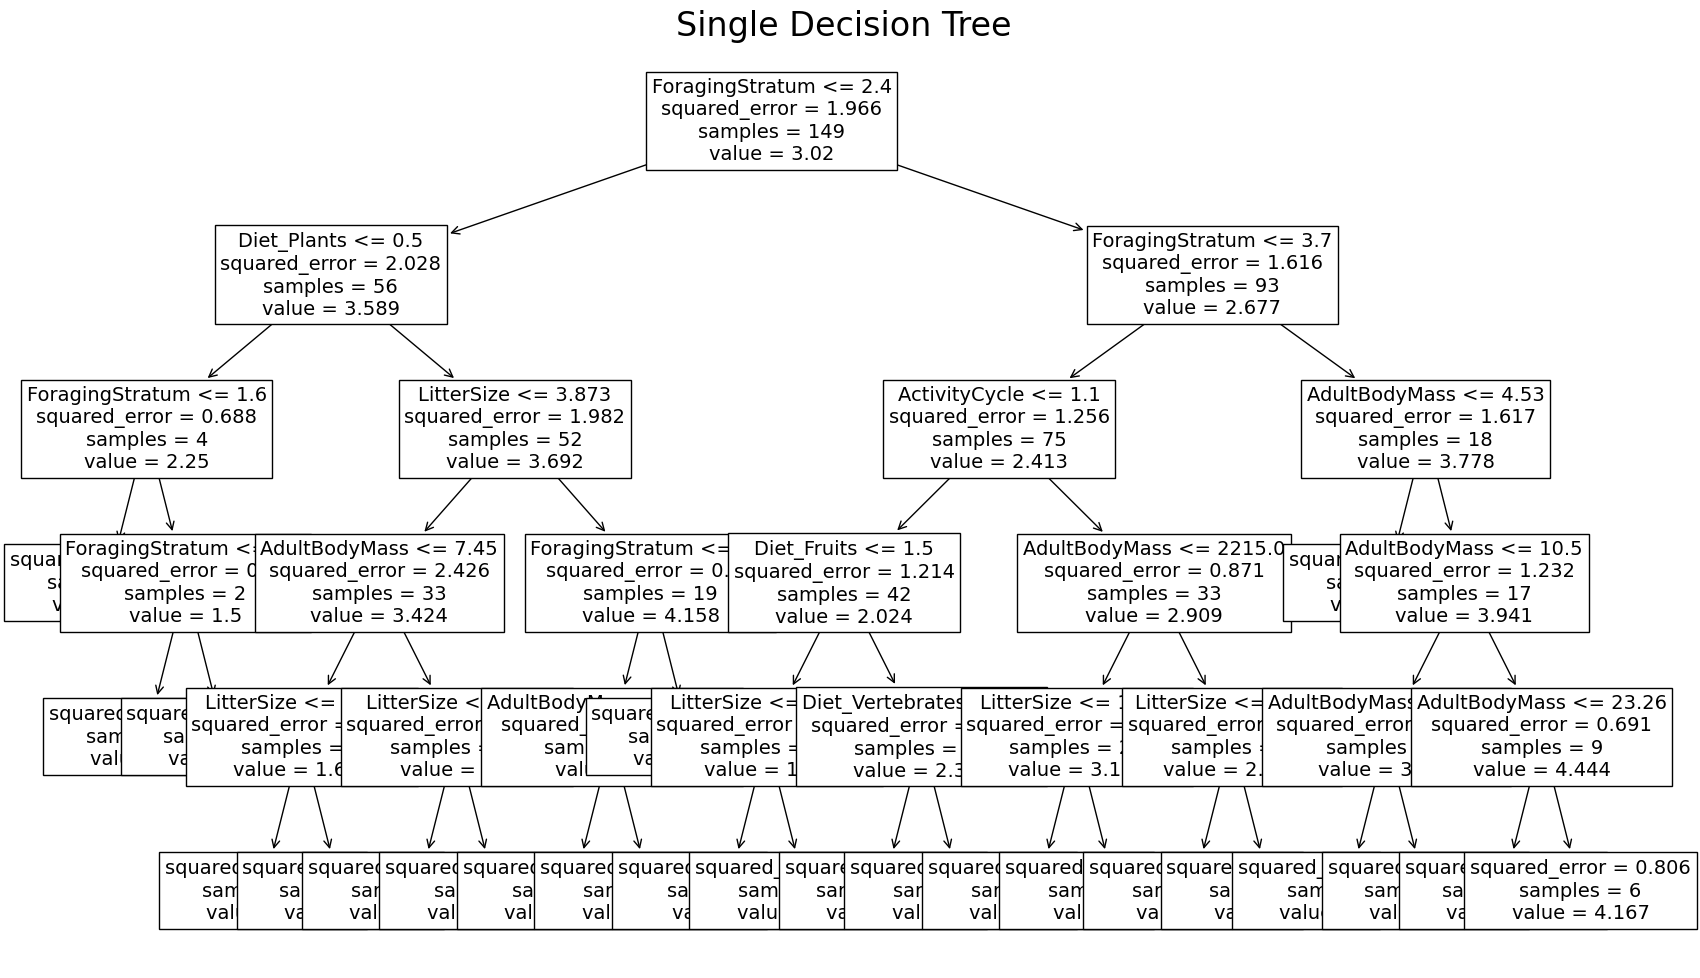

Single decision tree mse: 1.446


In [6]:
# Single decision tree model
single_tree = DecisionTreeRegressor(max_depth=5,
                                    random_state=808)

single_tree.fit(X_train, y_train)

tree_pred_y = single_tree.predict(X_test)

# Decision tree plot
plt.figure(figsize=(20, 12))
plot_tree(single_tree, feature_names=X_train.columns, fontsize=14)
plt.title('Single Decision Tree', fontsize=24)
plt.show()

# Mean Squared Error
print(f"Single decision tree mse: {mean_squared_error(y_test, tree_pred_y):.3f}")

Based on the way this tree looks, what would you guess the most important variable to be?

*Based on the way the tree looks and is split, I would guess the more important variable to be either `AdultBodyMass` or `LitterSize` as those are the variables deciding the  final split most frequently.*

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [7]:
# Construct random forest model
rf = RandomForestRegressor(random_state=808)

# Define parameter grid
param_grid = {
    "max_features": ["sqrt", 6, None],
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 4, 5, 6, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Conduct grid search to determine best parameters
gs = GridSearchCV(rf, 
                  param_grid=param_grid,
                  scoring="neg_mean_squared_error",
                  cv=5,
                  n_jobs=5)

# Train model
gs.fit(X_train, y_train)

# Best parameter values
best_params = gs.best_params_
print(f"Best parameters:\n{best_params}")

Best parameters:
{'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [8]:
# Construct model with best parameters
best_rf = gs.best_estimator_

best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_split=10,
                      n_estimators=200, random_state=808)

### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

Best parameters for Random Forest:
{'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest mse: 1.446
Single decision tree mse: 1.446
               Feature  Importance
0        AdultBodyMass    0.252498
4           LitterSize    0.159614
3      ForagingStratum    0.135450
2        ActivityCycle    0.074323
5   Diet_Invertebrates    0.073771
1       HabitatBreadth    0.055134
10         Diet_Plants    0.052759
8         Diet_Flowers    0.051023
6     Diet_Vertebrates    0.045647
7          Diet_Fruits    0.044715
9           Diet_Seeds    0.031989
11          Diet_Other    0.023077


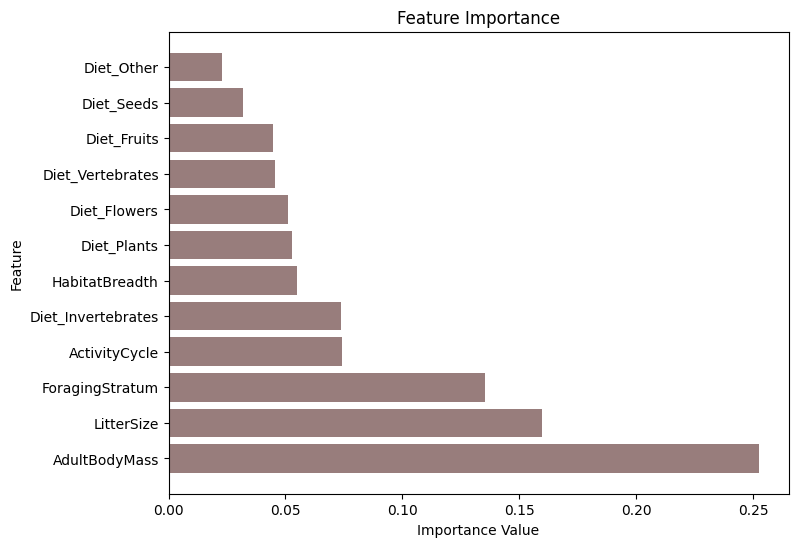

In [9]:
# Generate predictions
rf_pred_y = best_rf.predict(X_test)

# Best parameter values
print(f"Best parameters for Random Forest:\n{best_params}")

# Mean Squared Error
print(f"Random Forest mse: {mean_squared_error(y_test, rf_pred_y):.3f}")
print(f"Single decision tree mse: {mean_squared_error(y_test, tree_pred_y):.3f}")

# Extract feature importance
importances = best_rf.feature_importances_

# Combine with feature names
importance_df = pd.DataFrame({
    'Feature': X_test.columns,  
    'Importance': importances
})

# Sort by importance value
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

# Bar plot of importance values of features
plt.figure(figsize=(8, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color = "#987D7C")

plt.title('Feature Importance')
plt.ylabel('Feature')
plt.xlabel('Importance Value')
plt.show()

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

*I think this is probably wrong, but I can not determine where the error is coming from because it looks like the mse is being calculated correctly for both the single tree and the random forest predictions, and the mse for both the optimized random forest predictions and the single tree predictions are identical. Based on the Feature Importance graph above, it would appear that `AdultBodyMass` has the most influence on species' climate adaptability.*